## Introduction

This notebook is an exploration of translating the text found in images into geolocations

We begin by importing our dependancies and loading the labels

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import json
import seaborn as sns
from geopy import distance
import folium
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Imperial College London")

place = "london"
df  = pd.read_csv(f"../mappilary/train_val/{place}/database/postprocessed.csv")
df = df.set_index('key')
df_raw = pd.read_csv(f"../mappilary/train_val/{place}/database/raw.csv")
df_raw.set_index('key', inplace=True)
df = df.join(df_raw[['lat', 'lon']], on='key', how='left')
df.drop(columns=['Unnamed: 0', 'easting', 'northing', 'control_panel'], inplace=True)
# df.head()


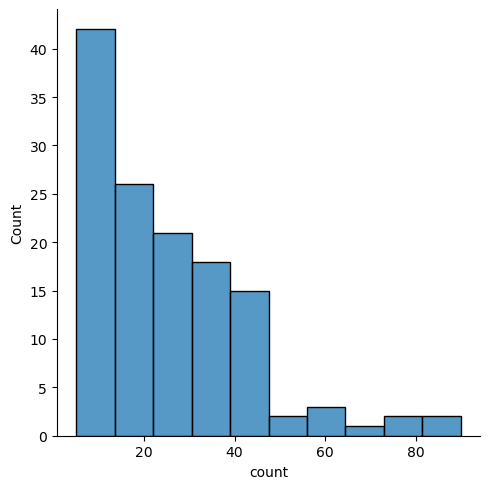

In [14]:
sns.displot(df['unique_cluster'].value_counts())

## Load OCR data

We load the text generated from the OCR model. 

We extract each line of text ensureing the watermark in the corner of images is excluded

In [138]:
with open("../notebooks/textPipleline.jsonl") as f:
    rows = f.readlines()
docs = [json.loads(l) for l in rows]
def bbox_overlap(a, b):

  # Calculate the area of overlap
  w_overlap = max(0, min(a[2], b[2]) - max(a[0], b[0]))
  h_overlap = max(0, min(a[3], b[3]) - max(a[1], b[1]))
  overlap_area = w_overlap * h_overlap

  # Calculate the area of box a
  area_a = (a[2] - a[0]) * (a[3] - a[1])

  # Calculate the percentage overlap
  if area_a > 0:
    overlap_percent = overlap_area / area_a
  else:
    overlap_percent = 0

  return overlap_percent

def only_punctuation(text):
  valid_chars = set(" -:,.!?()[]{}'\"/\\&%$@#*+=")
  return all(char in valid_chars for char in text)
def getPhotoLines(doc):
    items = []
    for block in doc["blocks"]:
        [[x1, y1],[x2, y2]] = block['geometry']
        overlap = bbox_overlap([20, doc["dimensions"][1] - 35, 60, doc["dimensions"][1] - 15],
                           [x1*doc["dimensions"][0], y1*doc["dimensions"][1], x2*doc["dimensions"][0], y2*doc["dimensions"][1]])
        
        
            
        for line in block["lines"]:
            text = ""
            for word in line["words"]:
                text =  text +" "+ word["value"]
            if overlap > 0.5 or only_punctuation(text) or len(text )< 3:
#                 print(f"skipping: {text}   {overlap}")
                pass
            else:
                items.append(text)
    return items


texts  = pd.DataFrame.from_records([{"lines": getPhotoLines(doc), "key":doc["key"]} for doc in docs])
texts.drop_duplicates(subset="key", inplace=True)
texts = texts.set_index("key")
texts
df = df.join(texts)
df['num_lines'] = df['lines'].apply(len)


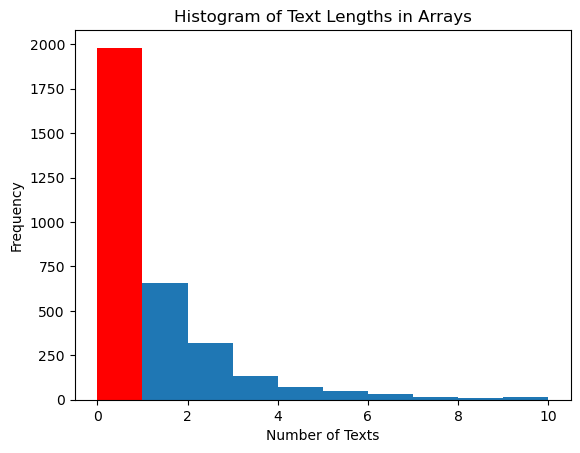

In [139]:
counts, bins, patches = plt.hist(df['num_lines'], bins=[0,1, 2, 3, 4,5,6,7,8,9,10,])
patches[0].set_facecolor('red')  
plt.xlabel('Number of Texts')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths in Arrays')
plt.show()

There are many samples in the dataset that have no text. This can be observed from the empty "lines" column in the dataframe.


Let's analyse the samples with text

In [140]:
df = df[df['num_lines'] > 0]
df.head(n=20)

,unique_cluster,night,view_direction,lat,lon,lines,num_lines
key,,,,,,,
JphRsbq4VD14g2bzV0EupQ,0,False,Forward,51.520099,-0.177805,[ V A],1
wyh5EIpEimZvNiuoUQMMMQ,1,False,Forward,51.521682,-0.178207,[ Schoot],1
ThYTiIv7Yul04qorQOTaSA,1,False,Forward,51.521691,-0.178220,"[ School, Maot - or]",2
ToquhjxuvSav9lzZWD4VQA,1,False,Forward,51.521697,-0.178234,[ School],1
tIVzx5srXUOohN1PttVTvQ,1,False,Forward,51.521707,-0.178252,"[ School, Map]",2
npIdkFbMvgvFYuvVHWbxmw,1,False,Forward,51.521719,-0.178271,[ School],1
-BHo1xYkJ1XW0aDdkOqrlg,1,False,Forward,51.521729,-0.178283,[ scnoou],1
BUAKf07iXa4twfO3YzsK9Q,1,False,Forward,51.521756,-0.178323,[ Tn],1
kC7DMzXu7gkW96WbCYzKKQ,1,False,Forward,51.521765,-0.178341,[ it],1


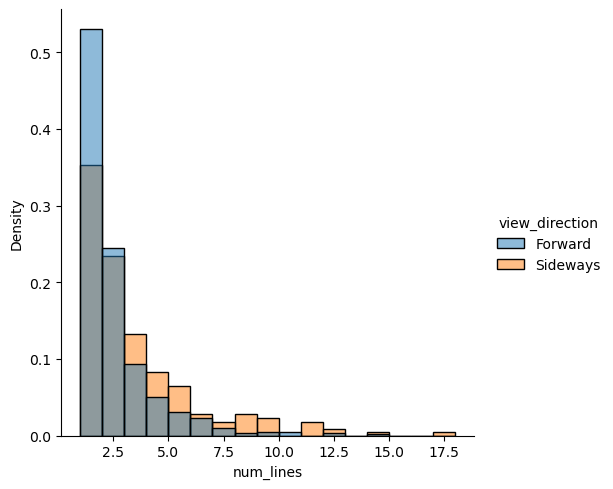

In [141]:
sns.displot(
    df, x="num_lines", hue="view_direction",  stat="density", common_norm=False,
    binwidth=1, height=5,
)

## Observations 

We see that sizeways imagery has proportanally more text extracted

In [153]:



def display_results(key, df, locations):
    row = df.loc[key]
    map_center=[row['lat'] ,row['lon']]
    mymap = folium.Map(location=map_center, zoom_start=18)
    folium.Marker(
        location=map_center,
        tooltip="groundtruth",
        popup="Ground Truth",
        icon=folium.Icon(color="green"),
        ).add_to(mymap)

    for location in locations:
        if location is None:
            continue
        print(distance.distance((row['lat'] ,row['lon']), (location.latitude,location.longitude)).km)
        folium.Marker(location=[location.latitude,location.longitude],
                    popup=location.address).add_to(mymap)




    tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
        ).add_to(mymap)
    folium.LayerControl().add_to(mymap)  
    return mymap

a-yyP31oSzRfiWZItRCfnA
[' ESSO', ' CUT']
Sideways


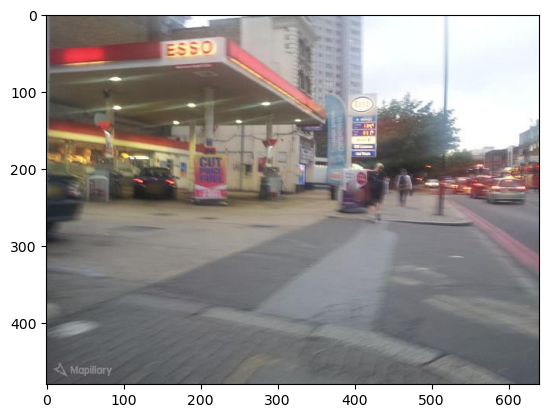

Esso, 24, Hindenburgring, Postdörfle, Weststadt, Ulm, Baden-Württemberg, 89077, Deutschland
Cut, Alba, 517206, România


In [150]:

img = Image.open(f"../mappilary/train_val/{place}/database/images/{docs[59]['key']}.jpg")
key = "a-yyP31oSzRfiWZItRCfnA"
print(key)
print(df.loc[key]['lines'])
print(df.loc[key]['view_direction'])
plt.imshow(img)
plt.show()
locations = [ geolocator.geocode(text) for text in df.loc[key]['lines'] if text is not None]
for location in locations:
    print(location)

In [151]:
display_results(key, df, locations)

806.081753195902
1850.5217834697899


Note, In this view for each text segment we are only considering the first resolved location, If we were to display all of them there would be many

![alt text](image.png)

sSs5DrBBgK2kYuKxy5UHeQ
[' Ring road', ' (A3,A2.A13:', ' The City', ' Vauxhail Bridge', ' (A: 202)', ' Westminster', ' (A302)']
Forward


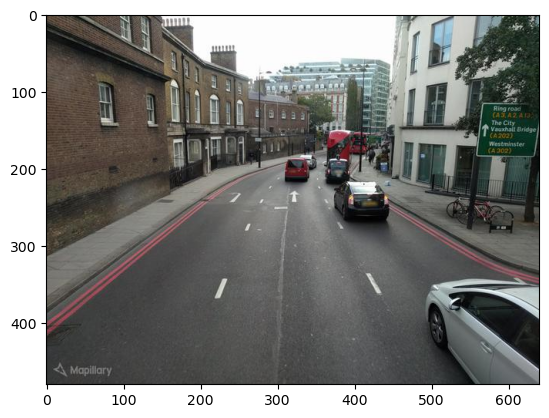

Ring Road, Kampala, Central Region, Uganda
A2, Innenstadt, Innenstadt/Jungbusch, Mannheim, Baden-Württemberg, 68159, Deutschland
City of London, Greater London, England, United Kingdom
None
A-202, Calatayud, Comunidad de Calatayud, Zaragoza, Aragón, 50300, España
Westminster, Millbank, City of Westminster, Greater London, England, SW1P 3JX, United Kingdom
Westminster Bridge, Lambeth, London Borough of Lambeth, City of Westminster, Greater London, England, SW1A 2JH, United Kingdom
6451.008982366544
650.0937164170153
4.1949220866188455
1134.5425853520678
1.3471195869899384
1.666792870957091


In [154]:
# sSs5DrBBgK2kYuKxy5UHeQ
key = "sSs5DrBBgK2kYuKxy5UHeQ"

img = Image.open(f"../mappilary/train_val/{place}/database/images/{key}.jpg")
print(key)
print(df.loc[key]['lines'])
print(df.loc[key]['view_direction'])
plt.imshow(img)
plt.show()
locations = [ geolocator.geocode(text) for text in df.loc[key]['lines'] if text is not None]
for location in locations:
    print(location)

display_results(key, df, locations)

Mmv38ANrjW68NDpbVJGPnQ
[' Dexters']
Forward


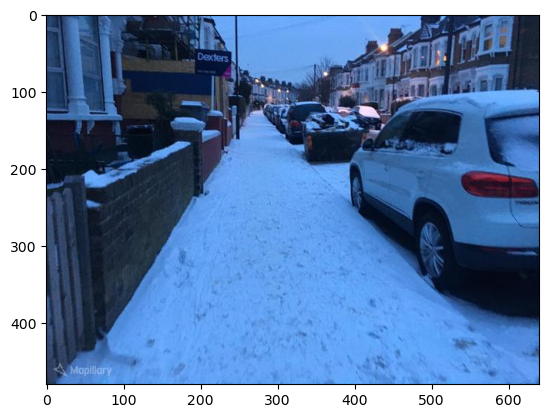

Dexters, 14, Culford Gardens, Hans Town, Chelsea, Royal Borough of Kensington and Chelsea, London, Greater London, England, SW3 2AQ, United Kingdom
6.0495182879393505


In [155]:

key = "Mmv38ANrjW68NDpbVJGPnQ"

img = Image.open(f"../mappilary/train_val/{place}/database/images/{key}.jpg")
print(key)
print(df.loc[key]['lines'])
print(df.loc[key]['view_direction'])
plt.imshow(img)
plt.show()
locations = [ geolocator.geocode(text) for text in df.loc[key]['lines'] if text is not None]
for location in locations:
    print(location)

display_results(key, df, locations)